## **Models**

#### **Load Cleaned Dataset**

In [2]:
import pandas as pd
import numpy as np

df = pd.read_pickle('pipe_leak_training_dataset_fresh.pkl')

# keep rows with a valid label
df = df[df["target_leak"].isin([0, 1])].copy()
print(df.shape, df["target_leak"].value_counts())

(6260, 21) target_leak
0    5127
1    1133
Name: count, dtype: int64


#### **Feature engineering**

In [3]:
TARGET = "target_leak"

NUM_COLS = [
    c for c in [
        "final__Nominal Diameter",
        "final__PIPELINE AGE",
        "final__TOTAL LENGTH (KM)",
        "final__CAPACITY MLD",
        "event_year","event_month"
    ] if c in df.columns
]

CAT_COLS = [
    c for c in [
        "final__Material",
        "final__SYSTEM",
        "final__SUB SYSTEM"
    ] if c in df.columns
]

DROP_COLS = [
    c for c in [
        "final__PIPELINE NAME",
        "Functional Loc.",
        "Equipment",
        "Description",
        "Location_Description"
    ] if c in df.columns
]

FEATURE_COLS = NUM_COLS + CAT_COLS
print("NUM:", NUM_COLS)
print("CAT:", CAT_COLS)

NUM: ['final__Nominal Diameter', 'final__PIPELINE AGE', 'final__TOTAL LENGTH (KM)', 'final__CAPACITY MLD', 'event_year', 'event_month']
CAT: ['final__Material', 'final__SYSTEM', 'final__SUB SYSTEM']


In [4]:
for c in CAT_COLS:
    df[c] = (df[c]
             .replace({None: np.nan, "None": np.nan, "": np.nan, "nan": np.nan})
             .fillna("Unknown"))


#### **Split Data**

In [5]:
df = df.sort_values("event_date").reset_index(drop=True)
cutoff = df["event_date"].quantile(0.8)
train = df[df["event_date"] < cutoff].copy()
test = df[df["event_date"] >= cutoff].copy()

# --- validation split from TRAIN (80/20 by date) ---
tr = train.sort_values("event_date").reset_index(drop=True)
cut_val = tr["event_date"].quantile(0.80)
train_core = tr[tr["event_date"] < cut_val].copy()
val_core   = tr[tr["event_date"] >= cut_val].copy()

print("cutoff:", cutoff)
print("train/test sizes:", train.shape, test.shape)
print(
    "train label balance:\n",
    train[TARGET].value_counts(normalize=True).round(3).to_dict()
)
print(
    "test label balance:\n",
    train[TARGET].value_counts(normalize=True).round(3).to_dict()
)

cutoff: 2024-04-15 00:00:00
train/test sizes: (4987, 21) (1273, 21)
train label balance:
 {0: 0.827, 1: 0.173}
test label balance:
 {0: 0.827, 1: 0.173}


#### **Preprocessor**

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Fallback to keep compatibility across sklearn versions
def make_ohe_dense():
    try:
        # sklearn >= 1.2
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # sklearn < 1.2
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("ohe", make_ohe_dense())
])

# Guard empty lists — ColumnTransformer dislikes None, but empty lists are fine.
NUM_COLS = NUM_COLS if len(NUM_COLS) else []
CAT_COLS = CAT_COLS if len(CAT_COLS) else []

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, NUM_COLS),
        ("cat", categorical_tf, CAT_COLS),
    ],
    remainder="drop"  # or "passthrough" if you want to keep extra columns
)


#### **Fit on train only, transform both splits, get names**

In [7]:
from sklearn.utils.class_weight import compute_class_weight

X_train = train[NUM_COLS + CAT_COLS].copy()
y_train = train[TARGET].values
X_test  = test[NUM_COLS + CAT_COLS].copy()
y_test  = test[TARGET].values

Xtr = preprocess.fit_transform(X_train)   # fit ONLY on train
Xte = preprocess.transform(X_test)

# class weights (to handle imbalance ~80/20)
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHT = {0: float(cw[0]), 1: float(cw[1])}

# Get feature names after preprocessing (works sklearn >=1.0)
try:
    feat_names = preprocess.get_feature_names_out()
except Exception:
    feat_names = None

print("Xtr:", Xtr.shape, "| Xte:", Xte.shape)
print("class_weight:", CLASS_WEIGHT)
if feat_names is not None:
    print("features:", list(feat_names))


Xtr: (4987, 12) | Xte: (1273, 12)
class_weight: {0: 0.6047780742178026, 1: 2.8859953703703702}
features: ['num__final__Nominal Diameter', 'num__final__PIPELINE AGE', 'num__final__TOTAL LENGTH (KM)', 'num__final__CAPACITY MLD', 'num__event_year', 'num__event_month', 'cat__final__Material_Steel', 'cat__final__Material_Unknown', 'cat__final__SYSTEM_Unknown', 'cat__final__SYSTEM_Upper Mgeni', 'cat__final__SUB SYSTEM_Midmar', 'cat__final__SUB SYSTEM_Unknown']


Text(0.5, 1.0, 'Class Distribution in Training Set')

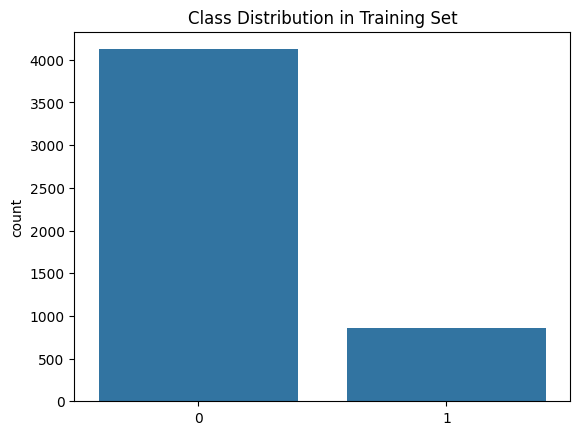

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")

#### **Logistic Regression**

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

lr = LogisticRegression(max_iter=5000, 
    class_weight="balanced", 
    solver="saga", 
    n_jobs=-1
)
lr.fit(Xtr, y_train)
proba_lr = lr.predict_proba(Xte)[:,1]
pred_lr = (proba_lr >= 0.5).astype(int)

print("LR ROC-AUC:", roc_auc_score(y_test, proba_lr).round(4))
print("LR PR-AUC :", average_precision_score(y_test, proba_lr).round(4))
print(classification_report(y_test, pred_lr, digits=3))


LR ROC-AUC: 0.4863
LR PR-AUC : 0.2021
              precision    recall  f1-score   support

           0      0.776     0.658     0.712      1004
           1      0.185     0.290     0.226       269

    accuracy                          0.581      1273
   macro avg      0.481     0.474     0.469      1273
weighted avg      0.651     0.581     0.610      1273



Text(0.5, 1.0, 'Confusion Matrix')

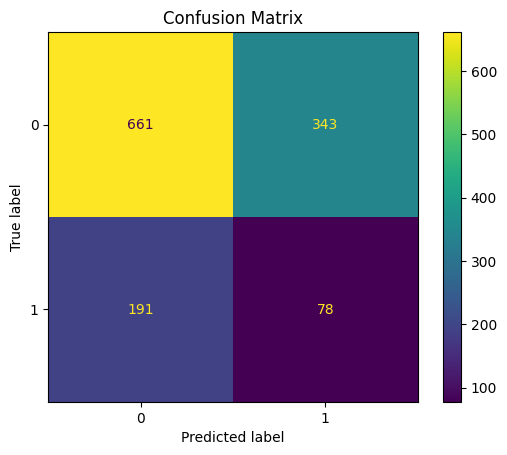

In [10]:
# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr, Xte, y_test)
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Logistic Regression Coefficients')

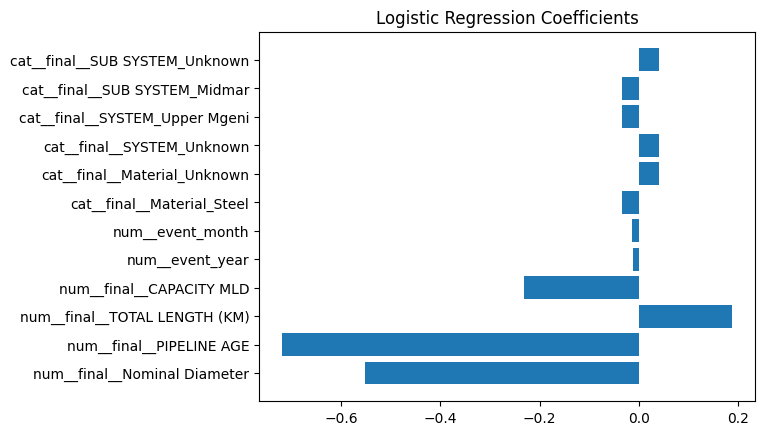

In [11]:
coeffs = lr.coef_[0]
plt.barh(feat_names, coeffs)
plt.title("Logistic Regression Coefficients")

Text(0.5, 1.0, 'ROC Curve (AUC = 0.49)')

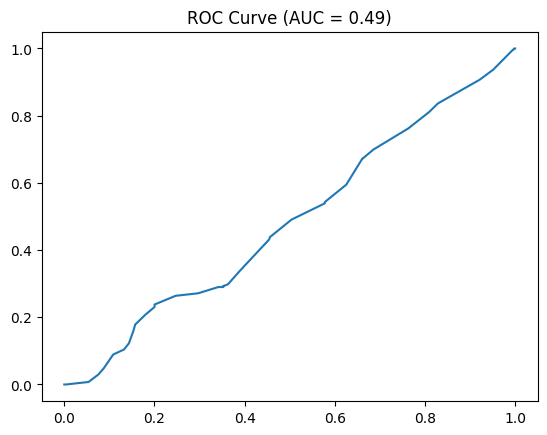

In [12]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(Xte)[:,1])
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {auc(fpr, tpr):.2f})")

Text(0.5, 1.0, 'Precision-Recall Curve')

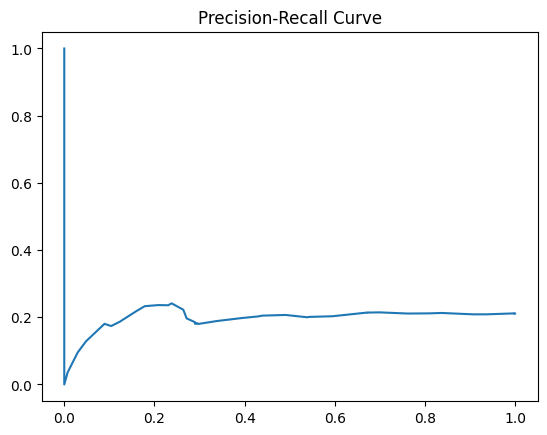

In [13]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, lr.predict_proba(Xte)[:,1])
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")

#### **Random Forest**

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)
rf.fit(Xtr, y_train)
proba_rf = rf.predict_proba(Xte)[:,1]
pred_rf = (proba_rf >= 0.5).astype(int)

print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf).round(4))
print("RF PR-AUC :", average_precision_score(y_test, proba_rf).round(4))
print(classification_report(y_test, pred_rf, digits=3))


RF ROC-AUC: 0.5181
RF PR-AUC : 0.2151
              precision    recall  f1-score   support

           0      0.810     0.403     0.539      1004
           1      0.225     0.647     0.334       269

    accuracy                          0.455      1273
   macro avg      0.518     0.525     0.436      1273
weighted avg      0.686     0.455     0.495      1273



Text(0.5, 1.0, 'Confusion Matrix')

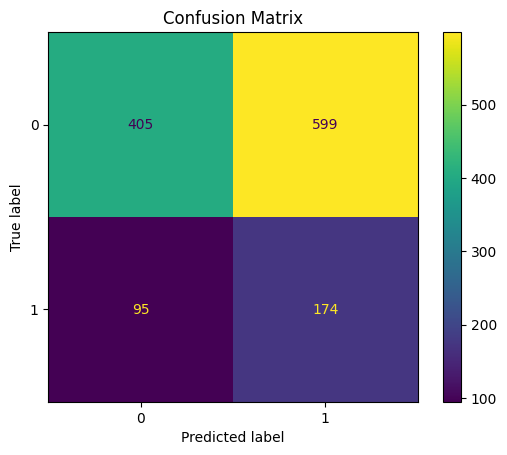

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf, Xte, y_test)
plt.title("Confusion Matrix")

Text(0.5, 1.0, 'Feature Importances')

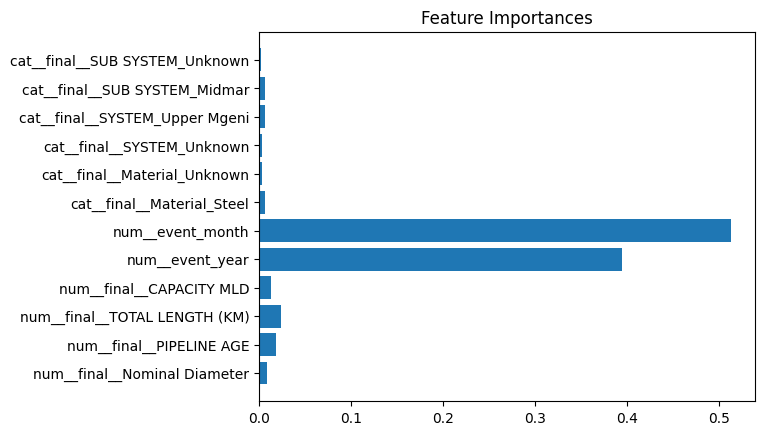

In [16]:
importances = rf.feature_importances_
plt.barh(feat_names, importances)
plt.title("Feature Importances")

Text(0.5, 1.0, 'Precision-Recall Curve')

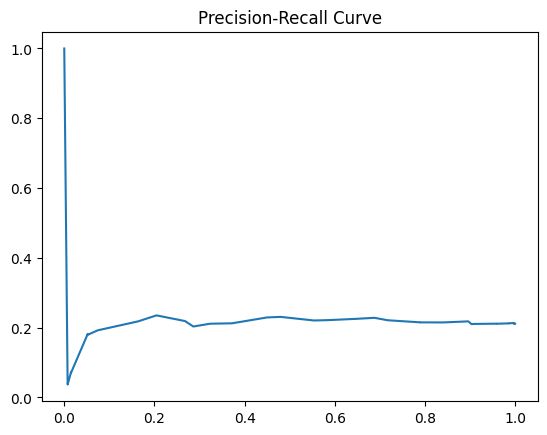

In [17]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, rf.predict_proba(Xte)[:,1])
plt.plot(recall, precision)
plt.title("Precision-Recall Curve")

Text(0.5, 1.0, 'ROC Curve (AUC = 0.52)')

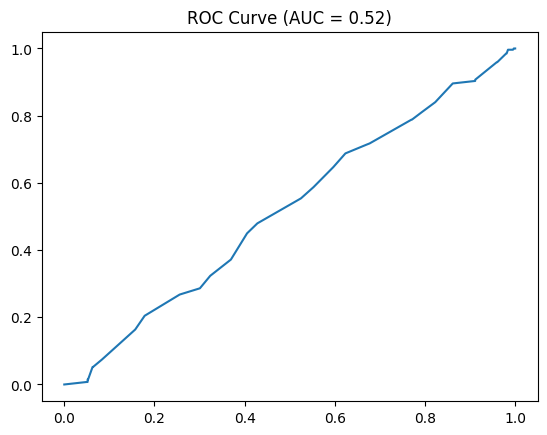

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(Xte)[:,1])
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {auc(fpr, tpr):.2f})")

#### **Deep Neural Network**

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks

def make_dnn(input_dim: int):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dropout(0.30)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.20)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.AUC(curve="ROC", name="AUC_ROC"),
                 tf.keras.metrics.AUC(curve="PR",  name="AUC_PR")]
    )
    return model

dnn = make_dnn(Xtr.shape[1])
es = callbacks.EarlyStopping(
    monitor="val_AUC_PR", 
    mode="max", 
    patience=10, 
    restore_best_weights=True
)

hist = dnn.fit(
    Xtr, y_train,
    validation_split=0.2,  # from TRAIN only
    epochs=50,
    batch_size=256,
    class_weight=CLASS_WEIGHT,
    callbacks=[es],
    verbose=1
)

proba_dnn = dnn.predict(Xte, verbose=0).ravel()
pred_dnn = (proba_dnn >= 0.5).astype(int)

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
print("DNN ROC-AUC:", roc_auc_score(y_test, proba_dnn).round(4))
print("DNN PR-AUC :", average_precision_score(y_test, proba_dnn).round(4))
print(classification_report(y_test, pred_dnn, digits=3))


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - AUC_PR: 0.1753 - AUC_ROC: 0.5065 - loss: 0.6991 - val_AUC_PR: 0.1727 - val_AUC_ROC: 0.5056 - val_loss: 0.6308
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC_PR: 0.1875 - AUC_ROC: 0.5063 - loss: 0.7020 - val_AUC_PR: 0.1668 - val_AUC_ROC: 0.4920 - val_loss: 0.6650
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC_PR: 0.1984 - AUC_ROC: 0.5409 - loss: 0.7000 - val_AUC_PR: 0.1563 - val_AUC_ROC: 0.4832 - val_loss: 0.6775
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - AUC_PR: 0.1998 - AUC_ROC: 0.5363 - loss: 0.6769 - val_AUC_PR: 0.1620 - val_AUC_ROC: 0.4968 - val_loss: 0.6467
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - AUC_PR: 0.2049 - AUC_ROC: 0.5339 - loss: 0.6994 - val_AUC_PR: 0.1633 - val_AUC_ROC: 0.4990 - val_loss: 0.6467
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC_PR: 0.2015 - AUC_ROC: 0.5581 - loss: 0.6818 - val_AUC_PR: 0.1810 - val_AUC_ROC: 0.5258 - val_loss: 0.6397
Epoch 7/50
16/16 ━━━━

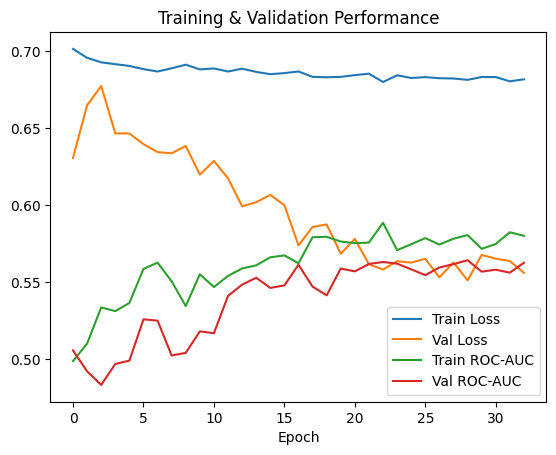

In [20]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.plot(hist.history['AUC_ROC'], label='Train ROC-AUC')
plt.plot(hist.history['val_AUC_ROC'], label='Val ROC-AUC')
plt.legend()
plt.title("Training & Validation Performance")
plt.xlabel("Epoch")
plt.show()

#### **Pick a better threshold (maximize F1 on VALIDATION)**

In [27]:
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, f1_score

# clone preprocessor so we don't overwrite the main one
preprocess_val = clone(preprocess)

# build X/y from DATAFRAMES (not from the transformer)
Xtr_core = preprocess_val.fit_transform(train_core[FEATURE_COLS])
ytr_core = train_core[TARGET].values

Xval = preprocess_val.transform(val_core[FEATURE_COLS])
yval = val_core[TARGET].values

print("Xtr_core:", Xtr_core.shape, "| Xval:", Xval.shape)

# small DNN for threshold search on VAL
tmp = make_dnn(Xtr_core.shape[1])
tmp.fit(
    Xtr_core, ytr_core,
    validation_data=(Xval, yval),
    epochs=50, batch_size=256,
    class_weight=CLASS_WEIGHT,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_AUC_PR", mode="max",
                                                patience=6, restore_best_weights=True)],
    verbose=0
)

val_proba = tmp.predict(Xval, verbose=0).ravel()

# choose threshold by max F1 on VAL (align PR arrays with thresholds)
prec, rec, thr = precision_recall_curve(yval, val_proba)
f1s = 2*prec*rec/(prec+rec+1e-12)
f1s_thr = f1s[1:]                 # thresholds align with prec[1:], rec[1:]
best_idx = int(np.nanargmax(f1s_thr)) if len(f1s_thr) else 0
best_thr = float(thr[best_idx]) if len(thr) else 0.5

print("Best threshold (VAL, F1):", round(best_thr, 4))
print("VAL F1 @0.5:", round(f1_score(yval, (val_proba >= 0.5).astype(int)), 4),
      "| @best:", round(f1_score(yval, (val_proba >= best_thr).astype(int)), 4))


Xtr_core: (3978, 12) | Xval: (1009, 12)
Best threshold (VAL, F1): 0.4879
VAL F1 @0.5: 0.2763 | @best: 0.3124


In [23]:
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score
# Ensure proba_dnn exists (computed with your main DNN on Xte)
proba_dnn = dnn.predict(Xte, verbose=0).ravel()
pred_dnn_05   = (proba_dnn >= 0.5).astype(int)
pred_dnn_best = (proba_dnn >= best_thr).astype(int)

print("\nTEST @0.5")
print(classification_report(y_test, pred_dnn_05, digits=3))
print(confusion_matrix(y_test, pred_dnn_05))

print("\nTEST @best_thr =", round(best_thr,4))
print(classification_report(y_test, pred_dnn_best, digits=3))
print(confusion_matrix(y_test, pred_dnn_best))



TEST @0.5
              precision    recall  f1-score   support

           0      0.788     0.996     0.880      1004
           1      0.000     0.000     0.000       269

    accuracy                          0.786      1273
   macro avg      0.394     0.498     0.440      1273
weighted avg      0.622     0.786     0.694      1273

[[1000    4]
 [ 269    0]]

TEST @best_thr = 0.3384
              precision    recall  f1-score   support

           0      0.782     0.760     0.771      1004
           1      0.189     0.208     0.198       269

    accuracy                          0.643      1273
   macro avg      0.485     0.484     0.484      1273
weighted avg      0.656     0.643     0.650      1273

[[763 241]
 [213  56]]


In [24]:
print("Have:", "FEATURE_COLS" in globals(), "preprocess" in globals(), "make_dnn" in globals(),
      "train_core" in globals(), "val_core" in globals(), "TARGET" in globals())
print("TARGET =", TARGET)
print("Missing in train_core:", set([TARGET] + FEATURE_COLS) - set(train_core.columns))
print("Missing in val_core  :", set([TARGET] + FEATURE_COLS) - set(val_core.columns))


Have: True True True True True True
TARGET = target_leak
Missing in train_core: set()
Missing in val_core  : set()


In [25]:
# balance data
from imblearn.over_sampling import SMOTE

# reshape data for SMOTE
X_reshaped = Xtr.reshape(Xtr.shape[0], -1)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_reshaped, y_train)

# X_balanced = X_balanced.reshape(-1, 42)

print(X_balanced.shape)
print(y_balanced.shape)


(8246, 12)
(8246,)


DNN ROC-AUC: 0.47
DNN PR-AUC : 0.2022


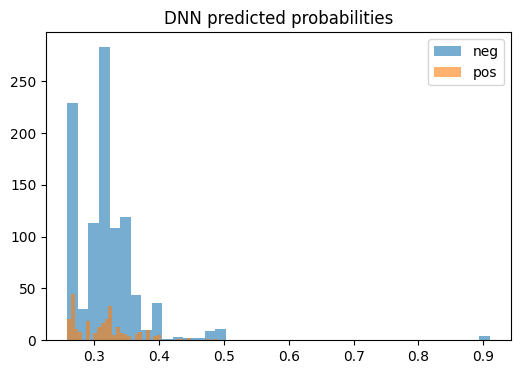

Proba percentiles: [0.31610116 0.33832419 0.37236217 0.39248282 0.48946974]


In [28]:
print("DNN ROC-AUC:", round(roc_auc_score(y_test, proba_dnn), 4))
print("DNN PR-AUC :", round(average_precision_score(y_test, proba_dnn), 4))

plt.figure(figsize=(6,4))
plt.hist(proba_dnn[y_test==0], bins=40, alpha=0.6, label='neg')
plt.hist(proba_dnn[y_test==1], bins=40, alpha=0.6, label='pos')
plt.title("DNN predicted probabilities"); plt.legend(); plt.show()

print("Proba percentiles:", np.percentile(proba_dnn, [50,75,90,95,99]))


In [26]:
# Pick an asset key you actually have
if "Functional Loc." in df.columns:
    KEY = "Functional Loc."
elif "final__PIPELINE NAME" in df.columns:
    KEY = "final__PIPELINE NAME"
else:
    KEY = "final__SUB SYSTEM"

# Sort by time (and key to make order deterministic)
df = df.sort_values(["event_date", KEY]).reset_index(drop=True)

# 1) Previous event (any)
df["prev_event_date_any"] = df.groupby(KEY)["event_date"].shift(1)
df["days_since_last_event"] = (df["event_date"] - df["prev_event_date_any"]).dt.days.fillna(9999)

# 2) Previous leak flag (0/1)
df["prev_leak_flag"] = df.groupby(KEY)["target_leak"].shift(1).fillna(0).astype(int)

# 3) Previous leak date (up to previous row in same key)
#    Do shift on the *Series grouped by KEY* so index stays aligned.
leak_dates = df["event_date"].where(df["target_leak"].eq(1))
df["prev_leak_date"] = leak_dates.groupby(df[KEY]).shift(1)
df["days_since_last_leak"] = (df["event_date"] - df["prev_leak_date"]).dt.days.fillna(9999)

# 4) Cumulative counts up to previous row (aligned with df)
df["cum_events"] = df.groupby(KEY).cumcount()

# Use transform to keep the original index when cumsumming
df["cum_leaks"] = (
    df.groupby(KEY)["target_leak"]
      .transform(lambda s: s.shift(1).fillna(0).cumsum())
    .astype(int)
)

# (Optional) sanity check
print(df[[KEY, "event_date", "target_leak",
          "days_since_last_event", "days_since_last_leak",
          "cum_events", "cum_leaks", "prev_leak_flag"]].head(12))

                   Functional Loc. event_date  target_leak  \
0   UW-II-W-MIDM-BDS-056-56A-PIPEL 2017-08-05            0   
1   UW-II-W-HENL-RWS-OPS-ADM-BUILD 2017-08-15            1   
2   UW-II-E-DVHA-BDS-069-69D-PIPEL 2017-09-23            0   
3   UW-II-E-MKON-SUP-OPS-WSH-BUILD 2017-12-01            0   
4   UW-II-W-HOWK-WWW-HOS-CHL-BUILD 2017-12-01            1   
5   UW-II-W-HOWK-WWW-HOS-PS3-BUILD 2017-12-05            1   
6   UW-II-W-HOWK-WWW-HOS-ADM-FLEET 2017-12-22            0   
7   UW-II-W-MIDM-BDS-056-GKR-RES01 2018-01-17            1   
8   UW-II-W-MIDM-BDS-056-56C-CH013 2018-02-08            0   
9   UW-II-W-MIDM-BDS-061-61G-PIPEL 2018-03-19            0   
10  UW-II-W-MIDM-BDS-063-63A-PIPEL 2018-03-19            0   
11  UW-II-E-ALBF-WWW-NOR-ADM-BUILD 2018-04-03            1   

    days_since_last_event  days_since_last_leak  cum_events  cum_leaks  \
0                  9999.0                9999.0           0          0   
1                  9999.0                9999